<a href="https://colab.research.google.com/github/hkaragah/google_colab_repo/blob/main/hands_on_ml_exercises/07_ensemble_learning_AdaBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensamble Learning: Adaptive Booting

__Disclaimer:__ This exercise is adopted from `"Hands-on Machine Learning with Scikit-Learn, Keras & Tensorflow (Third Edition)"` book written by `_Aurelien Geron_` publoshed by `_O'Reilly_`. I broke them down into smaller digestable snippets, made some modifications, and added some explanations so that I can undersatand them better. The porpuse of this notebook is just for me to understand the concept and have hands-on practice while reading the book material.

## Objective
Apply AdaBoost (Adaptive Boost) for ensamble learning

## Load Dataset

In [77]:
from sklearn.datasets import make_moons, load_iris, load_breast_cancer, load_wine, fetch_openml

from sklearn.ensemble import AdaBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import StandardScaler
from graphviz import Source
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, mean_squared_error
from IPython.display import Image
import time
import math


In [2]:
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) # default test_size = 0.25

print(f"Train sizes:{ X_train.shape}, {y_train.shape}")
print(f"Test sizes: {X_test.shape}, {y_test.shape}")

Train sizes:(375, 2), (375,)
Test sizes: (125, 2), (125,)


## AdaBoost Classifier

The following AdaBoost Classifiers use __Decision Stumps__ estimators which are decision trees with `max_depth=1`. The learning rate for `ada_2` is half of the value used for `ada_2`. <br>
The __learning rate__ (i.e., `learning_rate`) controls the contribution of each individual classifier (aka. 'weak learner') to the final model. It is a positive float value with a default value of 1.0.<br>
* _learning_rate > 1_: each weak learner has a stronger influence on the final prediction, leading to overfitting.
* _learning_rate < 1_: each weak learner has a reduced influence. This might require increasing the number of estimators (`_estimators`) to compensate and achieve good performance. Lower values can also make the model more resistant to overfitting by making the training process more gradual.

In [3]:
# AdaBoost classifier with 'decision stump' base extimator
ada_1 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=30,
    algorithm="SAMME.R",
    learning_rate=1.0,
    random_state=42)

ada_2 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=30,
    algorithm="SAMME.R",
    learning_rate=0.5,
    random_state=42)

In [4]:
ada_1.fit(X_train, y_train)
ada_2.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

In [5]:
print(f"AdaBoost 1 accuracy: {accuracy_score(y_test, ada_1.predict(X_test))}")
print(f"AdaBoost 2 accuracy: {accuracy_score(y_test, ada_2.predict(X_test))}")

AdaBoost 1 accuracy: 0.896
AdaBoost 2 accuracy: 0.904


In [6]:
print(f"AdaBoost 1 accuracy: {ada_1.score(X_test, y_test)}")
print(f"AdaBoost 2 accuracy: {ada_2.score(X_test, y_test)}")

AdaBoost 1 accuracy: 0.896
AdaBoost 2 accuracy: 0.904


The two scores are quite close. Let's check the bias and variance of the models over the training set.

In [7]:
ada1_scores = cross_val_score(ada_1, X_train, y_train, cv=5, scoring='accuracy')
ada2_scores = cross_val_score(ada_2, X_train, y_train, cv=5, scoring='accuracy')

In [8]:
print(f"learning_rate=1.0: (bias) {1-np.mean(ada1_scores):.3f}, (var) {np.var(ada1_scores):.5f}")
print(f"learning_rate=0.5: (bias) {1-np.mean(ada2_scores):.3f}, (var) {np.var(ada2_scores):.5f}")

learning_rate=1.0: (bias) 0.099, (var) 0.00033
learning_rate=0.5: (bias) 0.096, (var) 0.00074


The `ada_2` with the `learning_rate=0.5` achieved higher variance (124% higher) and slightly lower bias (3% lower) which could be an indication of overfitting. However, the score onthe test sets indicate a comparable performance.

In [9]:
def generate_meshgrid(X, n):

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    x1, x2 = np.meshgrid(np.linspace(x1_min, x1_max, n),
                         np.linspace(x2_min, x2_max, n))
    return x1, x2


def plot_decision_boundary(clf, X, y, ax, cmap):
    n = 100
    x1, x2 = generate_meshgrid(X, n) # x1 and x2 are of shape (n, n)

    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    ax.contourf(x1, x2, y_pred, alpha=0.2, cmap=cmap) # field
    ax.contour(x1, x2, y_pred, cmap="Greys", linewidths=[0.5,0.5,0.5], alpha=0.8) # line


def plot_points(X, y, ax, styles, ax_labels, s=50, alpha=0.5):
    for i in range(len(styles)):
        sns.scatterplot(x=X[:, 0][y == i], y=X[:, 1][y == i], ax=ax, marker=styles[i][0], color=styles[i][1], s=s, edgecolor='k', alpha=alpha)

    ax.set_xlabel(ax_labels[0])
    ax.set_ylabel(ax_labels[1], rotation=0)

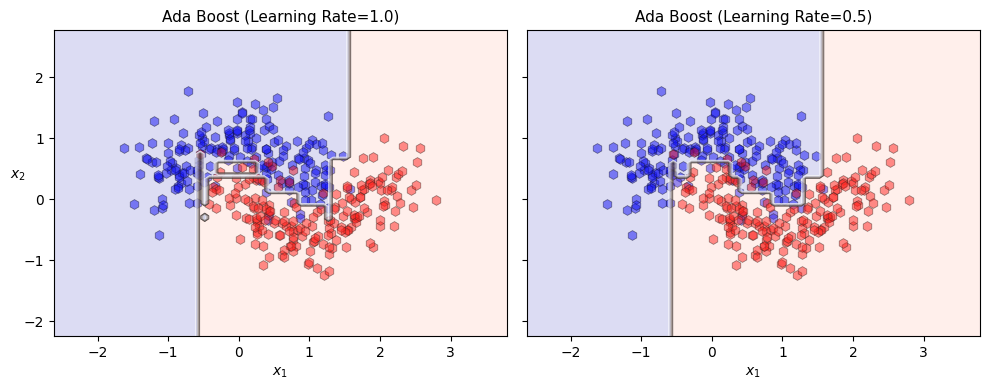

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)

custom_cmap = ListedColormap(['#5454C5', '#FFB19B'])

plot_points(X_train, y_train, axes[0], [("h", "blue"), ("h", "red")], ax_labels=[r"$x_1$", r"$x_2$"])
plot_decision_boundary(ada_1, X_train, y_train, axes[0], custom_cmap)
axes[0].set_title("Ada Boost (Learning Rate=1.0)", fontsize=11)

plot_points(X_train, y_train, axes[1], [("h", "blue"), ("h", "red")], ax_labels=[r"$x_1$", r"$x_2$"])
plot_decision_boundary(ada_2, X_train, y_train, axes[1], custom_cmap)
axes[1].set_title("Ada Boost (Learning Rate=0.5)", fontsize=11)

plt.tight_layout()
plt.show()

## Prediction Progress
Let's check out how the decision boundary improved in every stage of the training. First, I define a couple ofhelper functions, then use them to plot the decision boundary for each seccessive estimator for `ada_1` model.

In [37]:
def get_staged_pred(clf, X):
    n = 100
    x1, x2 = generate_meshgrid(X, n)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    return x1, x2, np.array(list(clf.staged_predict(X_new)))

def plot_progression(clf, X, y, styles, cmap, figsize):
    x1, x2, y_staged = get_staged_pred(clf, X)

    ncols = 10

    fig, axes = plt.subplots(nrows=math.ceil(clf.n_estimators/ncols), ncols=ncols, figsize=figsize, sharey=True, sharex=True)
    axes = axes.flatten()

    for i in range(y_staged.shape[0]):
        plot_points(X, y, axes[i], styles, ax_labels=[r"$x_1$", r"$x_2$"], s=10)
        y_pred = y_staged[i].reshape(x1.shape)

        axes[i].contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap) # field
        axes[i].contour(x1, x2, y_pred, cmap="Greys", linewidths=[0.3,0.3,0.3], alpha=0.8) # line
        # axes[i].set_title(f"Stage {i+1}", fontsize=9)
        axes[i].set_title(f"Stage {i+1}", fontsize=8, loc='left', pad=-8, y=1.0, x=0.02)



    plt.tight_layout()
    plt.show()

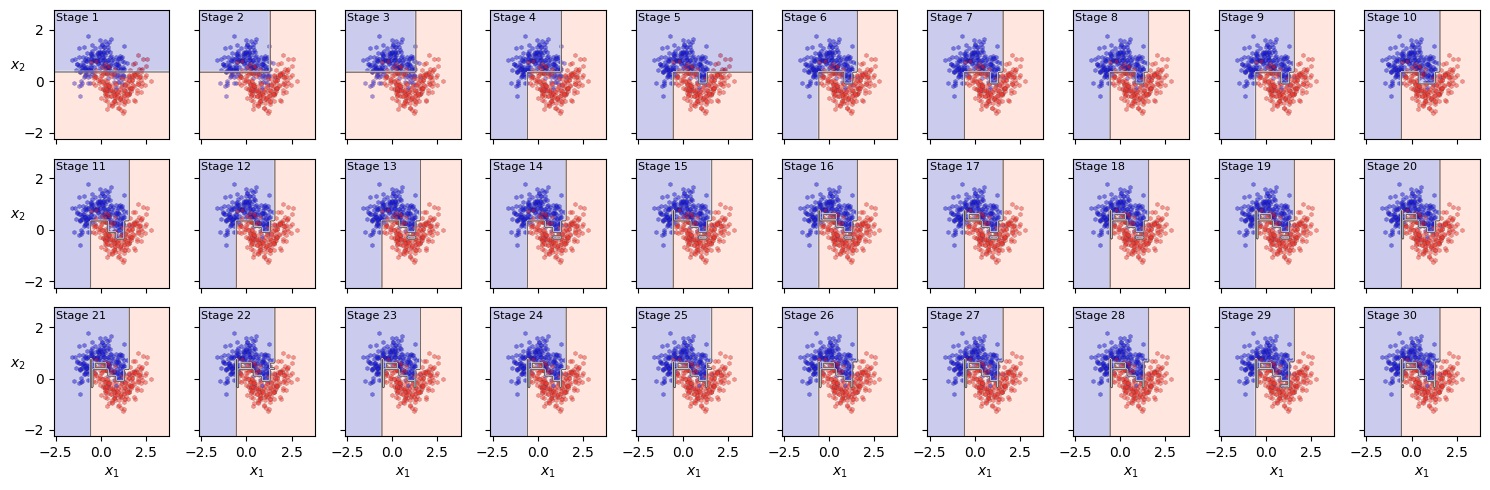

In [39]:
plot_progression(ada_1, X_train, y_train, [("h", "blue"), ("h", "red")], ListedColormap(['#5454C5', '#FFB19B']), figsize=(15,5))

Comparing the decision boundary of stage 1 to stage 30 reveals how much it improved from a straight line to a complex boundary.<br>
I am interested to see how the number of misclassfied intances improved when the models proceeded from one stage to another. Below I plot the ratio of misclassified samples for each estimator for both models.

In [13]:
y_staged_ada1 = np.array(list(ada_1.staged_predict(X_train))) # shape (30,375)
y_staged_ada2 = np.array(list(ada_2.staged_predict(X_train)))

In [14]:
# Numpy NumPy automatically broadcasts y_train across all rows of y_staged,
# effectively comparing each stage's predictions to the true labels for each sample.
# shape of y_train = (375,) which is a 1D array
ada1_missed = np.sum(y_staged_ada1 != y_train, axis=1) / len(y_train)
ada2_missed = np.sum(y_staged_ada2 != y_train, axis=1) / len(y_train)

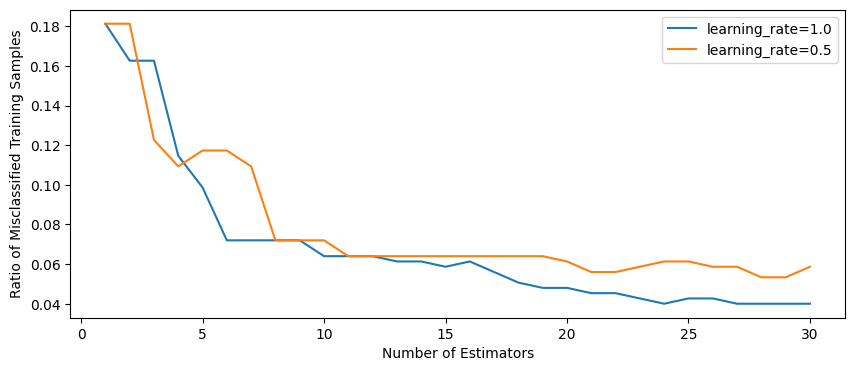

In [15]:
plt.figure(figsize=(10, 4))

sns.lineplot(x=range(1, ada_1.n_estimators+1), y=ada1_missed, label="learning_rate=1.0")
sns.lineplot(x=range(1, ada_2.n_estimators+1), y=ada2_missed, label="learning_rate=0.5")

plt.legend(loc="upper right")
plt.ylabel('Ratio of Misclassified Training Samples')
plt.xlabel('Number of Estimators')
plt.show()


the ratio reduced for both models, and as expected, the model with higher learning rate, demonstrated faster improvement.

## Iris Dataset

In [16]:
iris = load_iris()
X_iris = iris.data[:, 2:]
y_iris = iris.target
print(iris.feature_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


Let's use only 'petal length' and 'petal width'.

In [17]:
X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(X_iris, y_iris, random_state=42) # default test_size = 0.25

print(f"Train sizes:{ X_iris_train.shape}, {y_iris_train.shape}")
print(f"Test sizes: {X_iris_test.shape}, {y_iris_test.shape}")

Train sizes:(112, 2), (112,)
Test sizes: (38, 2), (38,)


I am going to create two AdaBoost classifiers, one with DecisionTreeClassifier with `max_depth=1` and another one with `max_depth=2`. This is a multiclass classification, and I use SAMME (_Stagewise Additive Modeling using Multiclass Exponential loss function_).

In [33]:
ada_iris1 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=10,
    algorithm="SAMME",
    learning_rate=1.0,
    random_state=42)

ada_iris2 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=10,
    algorithm="SAMME",
    learning_rate=1.0,
    random_state=42)


In [34]:
ada_iris1.fit(X_iris_train, y_iris_train)
ada_iris2.fit(X_iris_train, y_iris_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2),
                   n_estimators=10, random_state=42)

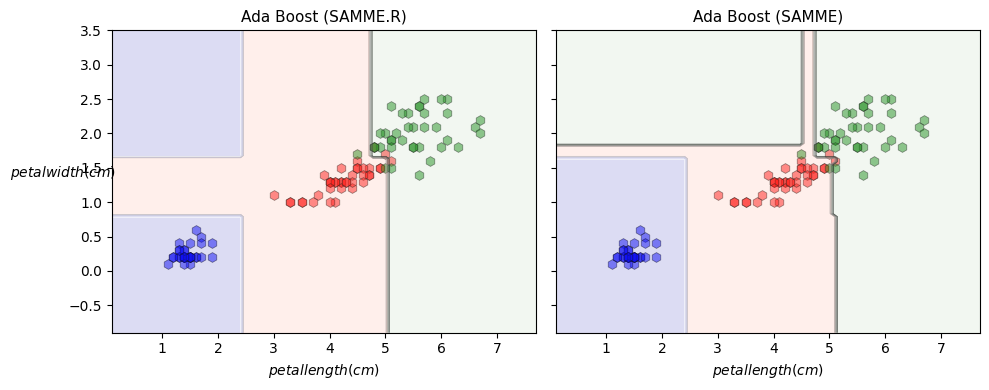

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)

custom_cmap = ListedColormap(['#5454C5', '#FFB19B', '#BEDBBB'])

plot_points(X_iris_train, y_iris_train, axes[0], [("h", "blue"), ("h", "red"), ("h", "green")], ax_labels=[r"$petal length (cm)$", r"$petal width (cm)$"])
plot_decision_boundary(ada_iris1, X_iris_train, y_iris_train, axes[0], custom_cmap)
axes[0].set_title("Ada Boost (SAMME.R)", fontsize=11)

plot_points(X_iris_train, y_iris_train, axes[1], [("h", "blue"), ("h", "red"), ("h", "green")], ax_labels=[r"$petal length (cm)$", r"$petal width (cm)$"])
plot_decision_boundary(ada_iris2, X_iris_train, y_iris_train, axes[1], custom_cmap)
axes[1].set_title("Ada Boost (SAMME)", fontsize=11)

plt.tight_layout()
plt.show()

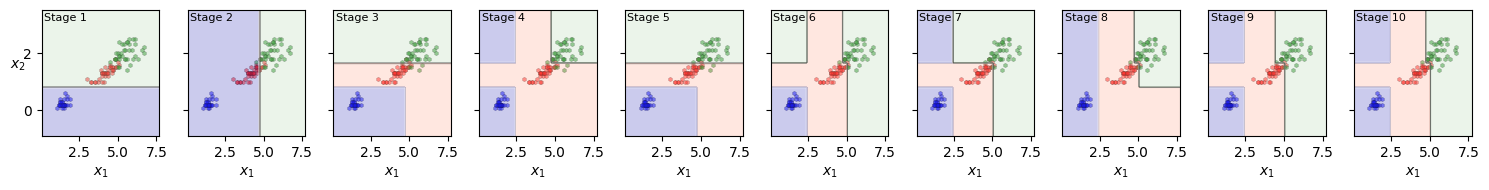

In [41]:
plot_progression(ada_iris1, X_iris_train, y_iris_train, [("h", "blue"), ("h", "red"), ("h", "green")], ListedColormap(['#5454C5', '#FFB19B', '#BEDBBB']), figsize=(15,2))

It seems there not much improvement after stage 6. Let's check the ratio of the misclassified instances over the training stages for both models.

In [42]:
y_staged_iris1 = np.array(list(ada_iris1.staged_predict(X_iris_train)))
y_staged_iris2 = np.array(list(ada_iris2.staged_predict(X_iris_train)))

iris1_missed = np.sum(y_staged_iris1 != y_iris_train, axis=1) / len(y_iris_train)
iris2_missed = np.sum(y_staged_iris2 != y_iris_train, axis=1) / len(y_iris_train)

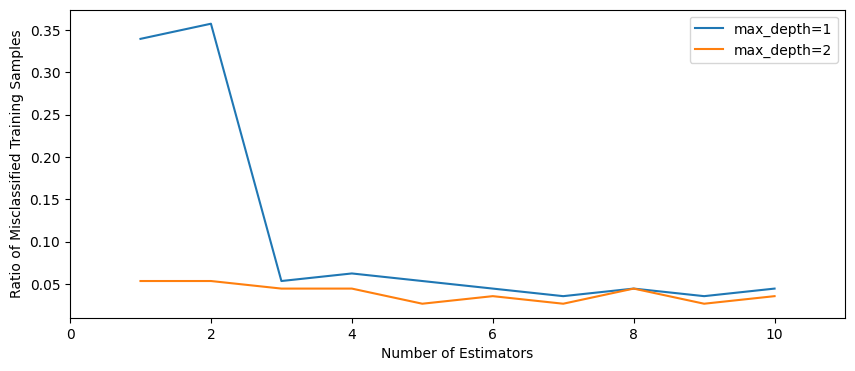

In [46]:
plt.figure(figsize=(10, 4))

sns.lineplot(x=range(1, ada_iris1.n_estimators+1), y=iris1_missed, label=f"max_depth={ada_iris1.estimator.max_depth}")
sns.lineplot(x=range(1, ada_iris2.n_estimators+1), y=iris2_missed, label=f"max_depth={ada_iris2.estimator.max_depth}")

plt.xlim(0, ada_iris1.n_estimators+1)
plt.legend(loc="upper right")
plt.ylabel('Ratio of Misclassified Training Samples')
plt.xlabel('Number of Estimators')
plt.show()

The AdaBoost classifier with `max_depth=2` starts off much better than the one with `max_depth=1`. Nevertheless, both achieve comparable accuracy after training the 3rd estimator. The AdaBoost with `max_depth=1` is able catch up very quickly!<br>
Let's check the models'scores.

In [50]:
print(f"AdaBoost (max_depth=1) accuracy: {ada_iris1.score(X_iris_test, y_iris_test):.3f}")
print(f"AdaBoost (max_depth=2) accuracy: {ada_iris2.score(X_iris_test, y_iris_test):.3f}")

AdaBoost (max_depth=1) accuracy: 1.000
AdaBoost (max_depth=2) accuracy: 1.000


In [53]:
# Create single decision tree classifier with max_depth=2
dtc = DecisionTreeClassifier(max_depth=2)
dtc.fit(X_iris_train, y_iris_train)
print(f"Decision Tree accuracy: {dtc.score(X_iris_test, y_iris_test):.3f}")

Decision Tree accuracy: 0.974


The AdaBoost model achieved 100% accuracy on the test set even with `max_depth=1`. The single DecisionTreeClassifier reached lower accuracy (about 2.6% lower) with `max_depth=2`.

## Breast Cancer Dataset

In [56]:
bc_data = load_breast_cancer()
X_bc = bc_data.data
y_bc = bc_data.target
print(f"shape of X: {X_bc.shape}")

shape of X: (569, 30)


In [57]:
X_bc_train, X_bc_test, y_bc_train, y_bc_test = train_test_split(X_bc, y_bc, random_state=42)

print(f"Train sizes:{ X_bc_train.shape}, {y_bc_train.shape}")
print(f"Test sizes: {X_bc_test.shape}, {y_bc_test.shape}")

Train sizes:(426, 30), (426,)
Test sizes: (143, 30), (143,)


In [61]:
# Create AdaBoost Classifier
ada_bc= AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=30,
    algorithm="SAMME",
    learning_rate=1.0,
    random_state=42)

# Create Decision Tree Classifier
dtc_bc = DecisionTreeClassifier(max_depth=3)

ada_bc.fit(X_bc_train, y_bc_train)
dtc_bc.fit(X_bc_train, y_bc_train)

DecisionTreeClassifier(max_depth=3)

In [63]:
y_staged_ada_bc = np.array(list(ada_bc.staged_predict(X_bc_train)))
ada_bc_missed = np.sum(y_staged_ada_bc != y_bc_train, axis=1) / len(y_bc_train)

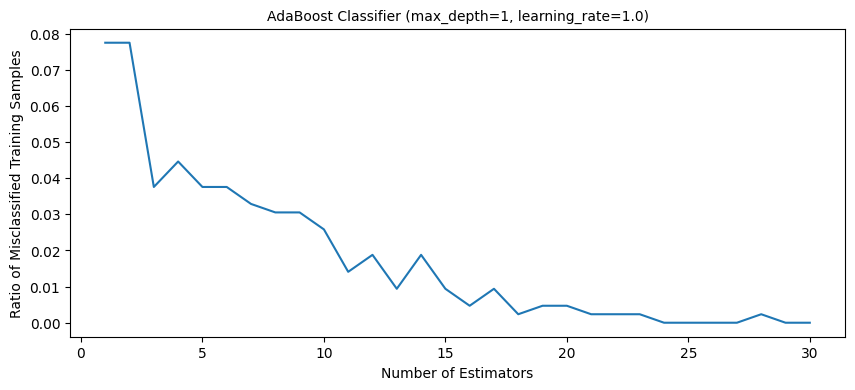

In [69]:
plt.figure(figsize=(10, 4))

sns.lineplot(x=range(1, ada_bc.n_estimators+1), y=ada_bc_missed)
plt.title("AdaBoost Classifier (max_depth=1, learning_rate=1.0)", fontsize=10)
plt.xlabel('Number of Estimators')
plt.ylabel('Ratio of Misclassified Training Samples')
plt.show()

In [70]:
print(f"AdaBoost accuracy: {ada_bc.score(X_bc_test, y_bc_test):.3f}")
print(f"Decision Tree accuracy: {dtc_bc.score(X_bc_test, y_bc_test):.3f}")

AdaBoost accuracy: 0.972
Decision Tree accuracy: 0.965


## Wine Dataset

In [72]:
wine = load_wine()
X_wine = wine.data
y_wine = wine.target

X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(X_wine, y_wine, random_state=42)

print(f"Train sizes:{ X_wine_train.shape}, {y_wine_train.shape}")
print(f"Test sizes: {X_wine_test.shape}, {y_wine_test.shape}")

Train sizes:(133, 13), (133,)
Test sizes: (45, 13), (45,)


In [73]:
ada_wine = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=30,
    algorithm="SAMME",
    learning_rate=1.0,
    random_state=4)

dtc_wine = DecisionTreeClassifier(max_depth=3)

ada_wine.fit(X_wine_train, y_wine_train)
dtc_wine.fit(X_wine_train, y_wine_train)

DecisionTreeClassifier(max_depth=3)

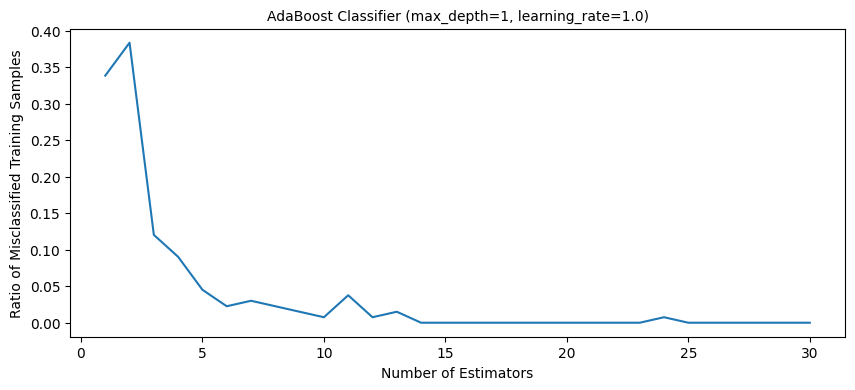

In [74]:
y_staged_wine = np.array(list(ada_wine.staged_predict(X_wine_train)))
ada_wine_missed = np.sum(y_staged_wine != y_wine_train, axis=1) / len(y_wine_train)

plt.figure(figsize=(10, 4))
sns.lineplot(x=range(1, ada_wine.n_estimators+1), y=ada_wine_missed)
plt.title("AdaBoost Classifier (max_depth=1, learning_rate=1.0)", fontsize=10)
plt.xlabel('Number of Estimators')
plt.ylabel('Ratio of Misclassified Training Samples')
plt.show()

In [76]:
print(f"AdaBoost accuracy: {ada_wine.score(X_wine_test, y_wine_test):.3f}")
print(f"Decision Tree accuracy: {dtc_wine.score(X_wine_test, y_wine_test):.3f}")

AdaBoost accuracy: 0.911
Decision Tree accuracy: 0.956


## MNIT Dataset

In [79]:
X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')

In [83]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

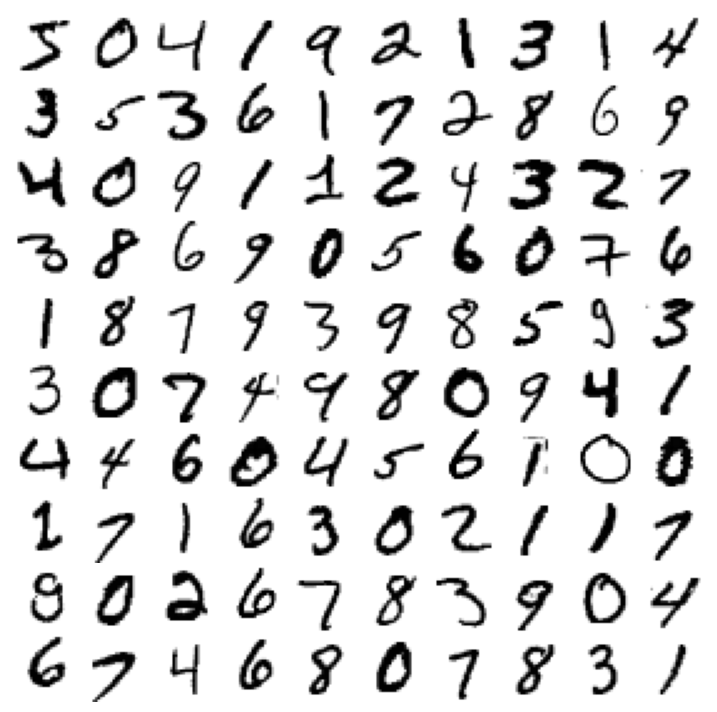

In [85]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X_mnist[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [86]:
X_mnist_train, X_mnist_test, y_mnist_train, y_mnist_test = train_test_split(X_mnist, y_mnist, test_size=0.2, random_state=42)

In [93]:
ada_mnist1 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    algorithm="SAMME",
    learning_rate=1.0,
    random_state=42)

ada_mnist2 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=3),
    n_estimators=100,
    algorithm="SAMME",
    learning_rate=1.0,
    random_state=42)

In [94]:
ada_mnist1.fit(X_mnist_train, y_mnist_train)
ada_mnist2.fit(X_mnist_train, y_mnist_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3),
                   n_estimators=100, random_state=42)

In [95]:
y_staged_ada_mnist1 = np.array(list(ada_mnist1.staged_predict(X_mnist_train)))
ada_mnist1_missed = np.sum(y_staged_ada_mnist1 != y_mnist_train, axis=1) / len(y_mnist_train)

y_staged_ada_mnist2 = np.array(list(ada_mnist2.staged_predict(X_mnist_train)))
ada_mnist2_missed = np.sum(y_staged_ada_mnist2 != y_mnist_train, axis=1) / len(y_mnist_train)

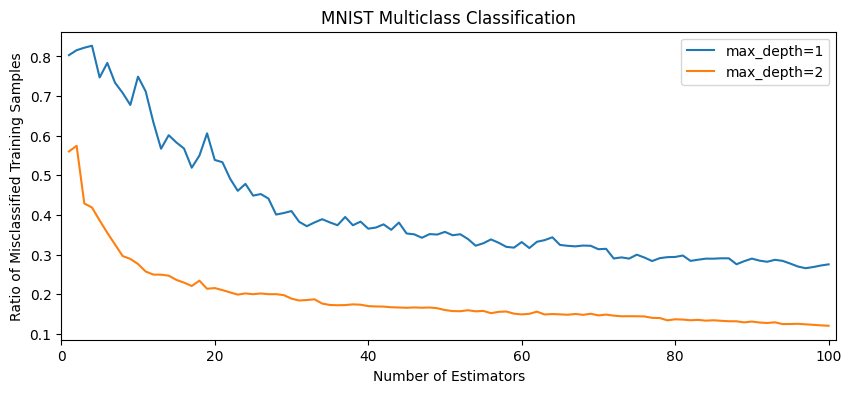

In [96]:
plt.figure(figsize=(10, 4))

sns.lineplot(x=range(1, ada_mnist1.n_estimators+1), y=ada_mnist1_missed, label=f"max_depth={ada_iris1.estimator.max_depth}")
sns.lineplot(x=range(1, ada_mnist2.n_estimators+1), y=ada_mnist2_missed, label=f"max_depth={ada_iris2.estimator.max_depth}")

plt.title("MNIST Multiclass Classification")
plt.xlim(0, ada_mnist1.n_estimators+1)
plt.legend(loc="upper right")
plt.ylabel('Ratio of Misclassified Training Samples')
plt.xlabel('Number of Estimators')
plt.show()

The model with `max_depth=2` is less jaggy and acieved better accuracy scores in each stage.

In [97]:
print(f"AdaBoost (max_depth=1) accuracy: {ada_mnist1.score(X_mnist_test, y_mnist_test):.3f}")
print(f"AdaBoost (max_depth=2) accuracy: {ada_mnist2.score(X_mnist_test, y_mnist_test):.3f}")

AdaBoost (max_depth=1) accuracy: 0.717
AdaBoost (max_depth=2) accuracy: 0.875


In [101]:
ada_mnist3 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=10),
    n_estimators=10,
    algorithm="SAMME",
    learning_rate=1.0,
    random_state=42)

ada_mnist3.fit(X_mnist_train, y_mnist_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=10),
                   n_estimators=10, random_state=42)

In [102]:
print(f"AdaBoost (max_depth=5) accuracy: {ada_mnist3.score(X_mnist_test, y_mnist_test):.3f}")

AdaBoost (max_depth=5) accuracy: 0.930


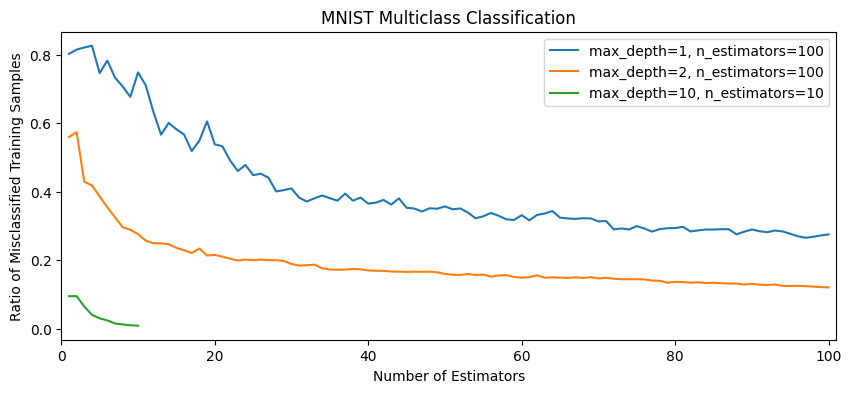

In [103]:
y_staged_ada_mnist3 = np.array(list(ada_mnist3.staged_predict(X_mnist_train)))
ada_mnist3_missed = np.sum(y_staged_ada_mnist3 != y_mnist_train, axis=1) / len(y_mnist_train)

plt.figure(figsize=(10, 4))

sns.lineplot(x=range(1, ada_mnist1.n_estimators+1), y=ada_mnist1_missed, label=f"max_depth={ada_iris1.estimator.max_depth}, n_estimators={ada_mnist1.n_estimators}")
sns.lineplot(x=range(1, ada_mnist2.n_estimators+1), y=ada_mnist2_missed, label=f"max_depth={ada_iris2.estimator.max_depth}, n_estimators={ada_mnist2.n_estimators}")
sns.lineplot(x=range(1, ada_mnist3.n_estimators+1), y=ada_mnist3_missed, label=f"max_depth={ada_mnist3.estimator.max_depth}, n_estimators={ada_mnist3.n_estimators}")

plt.title("MNIST Multiclass Classification")
plt.xlim(0, ada_mnist1.n_estimators+1)
plt.legend(loc="upper right")
plt.ylabel('Ratio of Misclassified Training Samples')
plt.xlabel('Number of Estimators')
plt.show()

Increasing the depth makes the model to achieve higher accuracy with smaller n_estimators. It should be noted that due to reduction in n_estimators the runtime also decreased dramatically.